# EfficientDet Training Notebook


Find the ready to use deployed version on Colab : https://colab.research.google.com/drive/1qpKUsWzwebEyTZcOMHS15i5k9xzcRgXg?usp=sharing

## 1. Setup
The pipeline works best on atleast 12GB VRAM with Nvidia Apex for mixed precision learning, otherwise reduce batch size or image size (currently 1024x1024).

In [ ]:
# Necessary when running on Google Colab
!pip install --upgrade --force-reinstall --no-deps kaggle
!pip install --upgrade --force-reinstall --no-deps albumentations

In [ ]:
!lscpu |grep 'Model name'

Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz


In [ ]:
!nvidia-smi

Sat Aug  1 13:20:38 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
os.environ['KAGGLE_USERNAME']="Enter your Kaggle API Credentials here"
os.environ['KAGGLE_KEY']="Or directly use .json file"

In [ ]:
# Necessary imports
!kaggle datasets download -d shonenkov/omegaconf
!unzip omegaconf.zip -d omegaconf
!rm -rf omegaconf.zip

!kaggle datasets download -d kaushal2896/pycocotools
!unzip pycocotools.zip -d pycocotools
!rm -rf pycocotools.zip

!kaggle datasets download -d greatgamedota/timm-package
!unzip timm-package.zip -d timm-package
!rm -rf timm-package.zip

!kaggle datasets download -d shonenkov/timm-efficientdet-pytorch
!unzip timm-efficientdet-pytorch.zip -d timm-efficientdet-pytorch
!rm -rf timm-efficientdet-pytorch.zip

!kaggle datasets download -d shonenkov/weightedboxesfusion
!unzip weightedboxesfusion.zip -d weightedboxesfusion
!rm -rf weightedboxesfusion.zip

!kaggle competitions download -c global-wheat-detection
!unzip global-wheat-detection.zip -d global-wheat-detection
!rm -rf global-wheat-detection.zip

!kaggle datasets download -d mathurinache/efficientdet
!unzip efficientdet.zip -d efficientdet
!rm -rf efficientdet.zip

In [ ]:
# My best public weights for GWD - Use for Transfer learning purposes if required
!kaggle datasets download -d ii5m0k3ii/42mixup50
!unzip 42mixup50.zip -d saves
!rm -rf 42mixup50.zip

In [ ]:
!pip install --no-deps './timm-package/timm-0.1.26-py3-none-any.whl' > /dev/null
!pip install pycocotools

In [ ]:
!git clone https://github.com/NVIDIA/apex

In [6]:
import sys
sys.path.insert(0, "./timm-efficientdet-pytorch")
sys.path.insert(0, "./omegaconf")
sys.path.insert(0, "./weightedboxesfusion")
sys.path.insert(0, "/content/apex")

import torch
import os
from datetime import datetime
import time
import random
import cv2
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from glob import glob
import apex.amp as amp
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain, DetBenchEval
from effdet.efficientdet import HeadNet
import gc

SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

## 2. Pre-Processing
The train labels (bounding boxes for wheat heads) were very noisy (incorrectly labeled, too big/small etc.)

In [7]:
marking = pd.read_csv('./global-wheat-detection/train.csv')

bboxs = np.stack(marking['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
for i, column in enumerate(['x', 'y', 'w', 'h']):
    marking[column] = bboxs[:,i]
marking.drop(columns=['bbox'], inplace=True)

marking = marking.drop([173,2169,118211,52868,117344,3687,2159,121633,113947])  # Faulty big boxes indexes

marking['area']=marking['w']*marking['h']
marking=marking[marking['area']<100000]
marking=marking[marking['area']>250]
marking=marking[marking['w']>10]    # this gets missed somehow even when w=0
marking=marking[marking['h']>10]

marking.drop(columns=['area'], inplace=True)
marking['x2']=marking['x']+marking['w']
marking['y2']=marking['y']+marking['h']

marking.drop(columns=['w'], inplace=True)
marking.drop(columns=['h'], inplace=True)

marking['x2']=marking['x2'].clip(upper=1023)
marking['x2']=marking['x2'].clip(upper=1023)

marking['w']=marking['x2']-marking['x']
marking['h']=marking['y2']-marking['y']

marking.drop(columns=['x2'], inplace=True)
marking.drop(columns=['y2'], inplace=True)
marking=marking.reset_index(drop=True)
marking

,image_id,width,height,source,x,y,w,h
0,b6ab77fd7,1024,1024,usask_1,834.0,222.0,56.0,36.0
1,b6ab77fd7,1024,1024,usask_1,226.0,548.0,130.0,58.0
2,b6ab77fd7,1024,1024,usask_1,377.0,504.0,74.0,160.0
3,b6ab77fd7,1024,1024,usask_1,834.0,95.0,109.0,107.0
4,b6ab77fd7,1024,1024,usask_1,26.0,144.0,124.0,117.0
...,...,...,...,...,...,...,...,...
147568,5e0747034,1024,1024,arvalis_2,64.0,619.0,84.0,95.0
147569,5e0747034,1024,1024,arvalis_2,292.0,549.0,107.0,82.0
147570,5e0747034,1024,1024,arvalis_2,134.0,228.0,141.0,71.0
147571,5e0747034,1024,1024,arvalis_2,430.0,13.0,184.0,79.0


In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

df_folds = marking[['image_id']].copy()
df_folds.loc[:, 'bbox_count'] = 1
df_folds = df_folds.groupby('image_id').count()
df_folds.loc[:, 'source'] = marking[['image_id', 'source']].groupby('image_id').min()['source']
df_folds.loc[:, 'stratify_group'] = np.char.add(
    df_folds['source'].values.astype(str),
    df_folds['bbox_count'].apply(lambda x: f'_{x // 15}').values.astype(str)
)
df_folds.loc[:, 'fold'] = 0

for fold_number, (train_index, val_index) in enumerate(skf.split(X=df_folds.index, y=df_folds['stratify_group'])):
    df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = fold_number

## 3. DataLoader Pipeline
Modifying the already imported EffDet pipeline. Added State of the Art augmentations like:  
Cutmix/Mosaic : https://arxiv.org/pdf/2004.12432.pdf  
Mixup: https://arxiv.org/pdf/1710.09412.pdf  
  
Upon extensive experimenting we found the ratio of Normal:Mixup:Cutmix :: 40:10:50 to be most optimal for this dataset.  
These were then passed through Albumentations.

In [9]:
def get_train_transforms():
    return A.Compose([
        A.RandomSizedCrop(
            min_max_height=(800, 800), height=1024, width=1024, p=0.3),
        A.OneOf([
            A.HueSaturationValue(hue_shift_limit=0.2,
                                 sat_shift_limit=0.2,
                                 val_shift_limit=0.2,
                                 p=0.6),
            A.RandomBrightnessContrast(
                brightness_limit=0.2, contrast_limit=0.2, p=0.6),
        ],
                p=0.5),
        A.ToGray(p=0.01),
        A.RandomRotate90(p=0.5),
        A.Flip(p=0.5),
        A.Resize(height=1024, width=1024, p=1),
        A.Cutout(
            num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.3),
        ToTensorV2(p=1.0),
    ],
                     p=1.0,
                     bbox_params=A.BboxParams(format='pascal_voc',
                                              min_area=0,
                                              min_visibility=0,
                                              label_fields=['labels']))

def get_valid_transforms():
    return A.Compose([
        A.Resize(height=1024, width=1024, p=1.0),
        ToTensorV2(p=1.0),
    ],
                     p=1.0,
                     bbox_params=A.BboxParams(format='pascal_voc',
                                              min_area=0,
                                              min_visibility=0,
                                              label_fields=['labels']))

In [10]:
TRAIN_ROOT_PATH = './global-wheat-detection/train'

class DatasetRetriever(Dataset):

    def __init__(self, marking, image_ids, transforms=None, test=False):
        super().__init__()

        self.image_ids = image_ids
        self.marking = marking
        self.transforms = transforms
        self.test = test

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        
        p=random.random()
        if self.test or p > 0.6:
            image, boxes = self.load_image_and_boxes(index)
        elif p > 0.5:
            image, boxes = self.load_mixup_images_and_boxes(index)
        else:
            image, boxes = self.load_cutmix_image_and_boxes(index)

        # there is only one class
        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])

        if self.transforms:
            for i in range(10):
                sample = self.transforms(**{
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels
                })
                if len(sample['bboxes']) > 0:
                    image = sample['image']
                    target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                    target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]  #yxyx: be warning
                    target['labels'] = torch.stack(sample['labels']) # <--- add this!
                    break

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def load_image_and_boxes(self, index):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{TRAIN_ROOT_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        records = self.marking[self.marking['image_id'] == image_id]
        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        return image, boxes

    def load_cutmix_image_and_boxes(self, index, imsize=1024):
        """ 
        Also known as Mosaic
        This implementation of cutmix author:  https://www.kaggle.com/nvnnghia 
        Refactoring and adaptation: https://www.kaggle.com/shonenkov
        """
        w, h = imsize, imsize
        s = imsize // 2
    
        xc, yc = [int(random.uniform(imsize * 0.25, imsize * 0.75)) for _ in range(2)]  # center x, y
        indexes = [index] + [random.randint(0, self.image_ids.shape[0] - 1) for _ in range(3)]

        result_image = np.full((imsize, imsize, 3), 1, dtype=np.float32)
        result_boxes = []

        for i, index in enumerate(indexes):
            image, boxes = self.load_image_and_boxes(index)
            if i == 0:
                x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
            elif i == 1:  # top right
                x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
                x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
            elif i == 2:  # bottom left
                x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, max(xc, w), min(y2a - y1a, h)
            elif i == 3:  # bottom right
                x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)
            result_image[y1a:y2a, x1a:x2a] = image[y1b:y2b, x1b:x2b]
            padw = x1a - x1b
            padh = y1a - y1b

            boxes[:, 0] += padw
            boxes[:, 1] += padh
            boxes[:, 2] += padw
            boxes[:, 3] += padh

            result_boxes.append(boxes)

        result_boxes = np.concatenate(result_boxes, 0)
        np.clip(result_boxes[:, 0:], 0, 2 * s, out=result_boxes[:, 0:])
        result_boxes = result_boxes.astype(np.int32)
        result_boxes = result_boxes[np.where((result_boxes[:,2]-result_boxes[:,0])*(result_boxes[:,3]-result_boxes[:,1]) > 0)]
        return result_image, result_boxes

    def load_mixup_images_and_boxes(self, index, imsize=1024, alpha=1.0):
        """ 
        This implementation of mixup author:  https://github.com/5m0k3 
        """
        images, bboxes = self.load_image_and_boxes(index)

        s_index = random.randint(0, self.image_ids.shape[0] - 1)
        shuffled_images, shuffled_bboxes= self.load_image_and_boxes(s_index)

        # Generate image weight (minimum 0.4 and maximum 0.6)
        #lam = np.clip(np.random.beta(alpha, alpha), 0.4, 0.6)
        lam=0.5
        
        # Weighted Mixup
        mixedup_images = lam*images + (1 - lam)*shuffled_images       
        mixedup_bboxes = np.concatenate((bboxes,shuffled_bboxes), 0)

        return mixedup_images, mixedup_bboxes

In [11]:
fold_number = 0    # Fold number to Validate on

train_dataset = DatasetRetriever(
    image_ids=df_folds[df_folds['fold'] != fold_number].index.values,
    marking=marking,
    transforms=get_train_transforms(),
    test=False,
)

validation_dataset = DatasetRetriever(
    image_ids=df_folds[df_folds['fold'] == fold_number].index.values,
    marking=marking,
    transforms=get_valid_transforms(),
    test=True,
)

Number of GT Boxes: 47


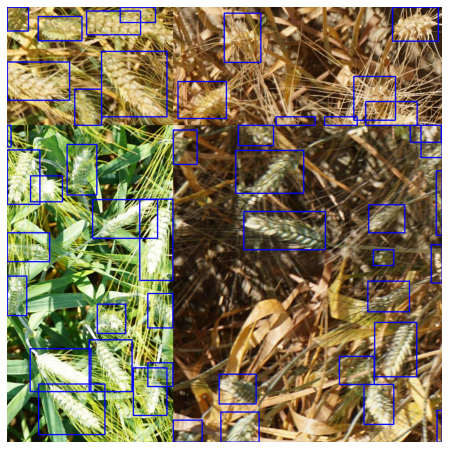

In [14]:
# A peak into the DataLoader output (Output Image shown is Cutmix/Mosaic augmented)
image, target, image_id = train_dataset[0]
boxes = target['boxes'].cpu().numpy().astype(np.int32)

numpy_image = image.permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(numpy_image, (box[1], box[0]), (box[3],  box[2]), (0, 0, 1), 2)

print(f'Number of GT Boxes: {len(boxes)}')

ax.set_axis_off()
ax.imshow(numpy_image);

## 4. Training Pipeline and Configurations
Top 3 Best checkpoints are saved on the basis of Validation loss alongside Last checkpoint.

In [15]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [16]:
import warnings

warnings.filterwarnings("ignore")

class Fitter:
    def __init__(self, model, device, config):
        self.config = config
        self.epoch = 0

        self.base_dir = '/content/Checkpoints/'
        if not os.path.exists(self.base_dir):
            os.makedirs(self.base_dir)

        self.log_path = f'{self.base_dir}/log.txt'
        self.best_summary_loss = 10**5

        self.model = model
        self.device = device

        param_optimizer = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [{
            'params': [
                p for n, p in param_optimizer
                if not any(nd in n for nd in no_decay)
            ],
            'weight_decay':
            0.001
        }, {
            'params':
            [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
            'weight_decay':
            0.0
        }]

        self.optimizer = torch.optim.AdamW(self.model.parameters(),
                                           lr=config.lr)
        self.scheduler = config.SchedulerClass(self.optimizer,
                                               **config.scheduler_params)
        self.log(f'Fitter prepared. Device is {self.device}')
        if self.config.apex:
            self.model, self.optimizer = amp.initialize(self.model,
                                                        self.optimizer,
                                                        opt_level='O1')

    def fit(self, train_loader, validation_loader):
        for e in range(self.config.n_epochs):
            if self.config.verbose:
                lr = self.optimizer.param_groups[0]['lr']
                timestamp = datetime.utcnow().isoformat()
                self.log(f'\n{timestamp}\nLR: {lr}')

            t = time.time()
            summary_loss = self.train_one_epoch(train_loader)

            self.log(
                f'[RESULT]: Train. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}'
            )
            self.save(f'{self.base_dir}/last-checkpoint.bin')

            t = time.time()
            summary_loss = self.validation(validation_loader)

            self.log(
                f'[RESULT]: Val. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}'
            )
            if summary_loss.avg < self.best_summary_loss:
                self.best_summary_loss = summary_loss.avg
                self.model.eval()
                self.save(
                    f'{self.base_dir}/best-checkpoint-{str(self.epoch).zfill(3)}epoch.bin'
                )
                for path in sorted(
                        glob(f'{self.base_dir}/best-checkpoint-*epoch.bin')
                )[:-3]:
                    os.remove(path)

            if self.config.validation_scheduler:
                self.scheduler.step(metrics=summary_loss.avg)

            self.epoch += 1

    def validation(self, val_loader):
        self.model.eval()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(val_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Val Step {step}/{len(val_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            with torch.no_grad():
                images = torch.stack(images)
                batch_size = images.shape[0]
                images = images.to(self.device).float()
                boxes = [
                    target['boxes'].to(self.device).float()
                    for target in targets
                ]
                labels = [
                    target['labels'].to(self.device).float()
                    for target in targets
                ]

                loss, _, _ = self.model(images, boxes, labels)
                summary_loss.update(loss.detach().item(), batch_size)

        return summary_loss

    def train_one_epoch(self, train_loader):
        self.model.train()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(train_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Train Step {step}/{len(train_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )

            images = torch.stack(images)
            images = images.to(self.device).float()
            batch_size = images.shape[0]
            boxes = [
                target['boxes'].to(self.device).float() for target in targets
            ]
            labels = [
                target['labels'].to(self.device).float() for target in targets
            ]

            self.optimizer.zero_grad()

            loss, _, _ = self.model(images, boxes, labels)

            if self.config.apex:
                with amp.scale_loss(loss, self.optimizer) as loss:
                    loss.backward()

            else:
                loss.backward()

            summary_loss.update(loss.detach().item(), batch_size)

            #             if (step+1) % self.config.accumulation_steps == 0:
            self.optimizer.step()
            #                 self.model.zero_grad()

            if self.config.step_scheduler:
                self.scheduler.step()

        return summary_loss

    def save(self, path):
        self.model.eval()
        torch.save(
            {
                'model_state_dict': self.model.model.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
                'scheduler_state_dict': self.scheduler.state_dict(),
                'best_summary_loss': self.best_summary_loss,
                'epoch': self.epoch,
            }, path)

    def load(self, path):
        checkpoint = torch.load(path)
        self.model.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.best_summary_loss = checkpoint['best_summary_loss']
        self.epoch = checkpoint['epoch'] + 1

    def log(self, message):
        if self.config.verbose:
            print(message)
        with open(self.log_path, 'a+') as logger:
            logger.write(f'{message}\n')

In [17]:
class TrainGlobalConfig:
    num_workers = 4
    batch_size = 2
    n_epochs = 50
    lr = 0.0003

    folder = 'effdet5-cutmix-augmix-mixup'

    # -------------------
    verbose = True
    verbose_step = 1
    # -------------------
    accumulation_steps = 2
    # --------------------
    step_scheduler = False  # do scheduler.step after optimizer.step
    validation_scheduler = True  # do scheduler.step after validation stage loss

    apex = True
    
    SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
    scheduler_params = dict(
        mode='min',
        factor=0.5,
        patience=1,
        verbose=False, 
        threshold=0.0001,
        threshold_mode='abs',
        cooldown=0, 
        min_lr=1e-8,
        eps=1e-08
    )

In [18]:
def collate_fn(batch):
    return tuple(zip(*batch))

def run_training():
    device = torch.device('cuda:0')
    net.to(device)

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=TrainGlobalConfig.batch_size,
        sampler=RandomSampler(train_dataset),
        pin_memory=True,
        drop_last=True,
        num_workers=TrainGlobalConfig.num_workers,
        collate_fn=collate_fn,
    )
    val_loader = torch.utils.data.DataLoader(
        validation_dataset, 
        batch_size=TrainGlobalConfig.batch_size,
        num_workers=TrainGlobalConfig.num_workers,
        shuffle=False,
        sampler=SequentialSampler(validation_dataset),
        pin_memory=True,
        collate_fn=collate_fn,
    )

    fitter = Fitter(model=net, device=device, config=TrainGlobalConfig)
    fitter.fit(train_loader, val_loader)

In [ ]:
def get_net():
    config = get_efficientdet_config('tf_efficientdet_d5')
    net = EfficientDet(config, pretrained_backbone=False)
    checkpoint = torch.load('/content/efficientdet/efficientdet_d5-ef44aea8.pth')
    net.load_state_dict(checkpoint)

    config.num_classes = 1
    config.image_size = 1024
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))

    return DetBenchTrain(net, config)

In [ ]:
def get_net_file(checkpoint_path):
    config = get_efficientdet_config('tf_efficientdet_d5')
    net = EfficientDet(config, pretrained_backbone=False)

    config.num_classes = 1
    config.image_size = 1024
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))

    checkpoint = torch.load(checkpoint_path)
    net.load_state_dict(checkpoint['model_state_dict'])

    del checkpoint
    gc.collect()

    net = DetBenchEval(net, config)
    net.eval();
    return net.cuda()

def get_resume_net(eval_net):
    config = get_efficientdet_config('tf_efficientdet_d5')
    net = EfficientDet(config, pretrained_backbone=False)

    config.num_classes = 1
    config.image_size = 1024
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))

    # checkpoint = torch.load(checkpoint_path)
    net.load_state_dict(eval_net.model.state_dict())

    # del checkpoint
    gc.collect()

    net = DetBenchTrain(net, config)
    net = net.train()
    return net.cuda()

In [ ]:
#Use these to resume from pretrained model
#old_net = get_net_file('/content/5SplitM50/best-checkpoint-021epoch.bin')
#net = get_resume_net(old_net)

#Use this to train from Scratch
net=get_net()

In [ ]:
run_training()

Fitter prepared. Device is cuda:0
Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic

2020-08-01T13:31:32.857876
LR: 0.0003
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
G

KeyboardInterrupt: ignored